In [1]:
#import packages
import pandas as pd
import sys
import matplotlib.pyplot as plt
from datetime import datetime
import logging
import numpy as np
import copy

#custom classes
from classes import classes as cl
from functions import functions as fc
from functions import routing as rt
from functions import simulated_annealing as sa
import random

plt.rcParams.update({'font.size': 22})
logging.basicConfig(filename="sa_worst_edge_opposite.log", level=logging.INFO)

init_path = 'output/initial_solution'
img_exp_path = 'output/graphs/sa_worst_edge_opposite/'

Initiation

In [2]:
fc.print_log("Starting initiation")
#create empty dict
initiation_objects = {'dict_depots': '', 'dict_sites': '', 'dict_plants': '', 'dict_jobs': '', 'dict_tours': '', 'list_days': ''}


objects = fc.initiate(initiation_objects,init_path,'final')

#load objects
list_days = objects['list_days']
dict_depots = objects['dict_depots']
dict_sites = objects['dict_sites']
dict_plants = objects['dict_plants']
dict_jobs = objects['dict_jobs']
dict_tours = objects['dict_tours']

#also create lists for convenience
list_depots = [dict_depots[element] for element in dict_depots]
list_sites = [dict_sites[element] for element in dict_sites]
list_plants = [dict_plants[element] for element in dict_plants]
list_jobs = [dict_jobs[element] for element in dict_jobs]
list_tours  = [dict_tours[element] for element in dict_tours]


fc.print_log("Done with initiation")

Starting initiation- t: 17:00:23
Starting initiation at 17:00:23- t: 17:00:23
Done with initiation- t: 17:00:25


In the first stage only one depot ist handled, so moves so its all about dropoff and pickup dates

In [3]:
#ov tours
for depot in dict_depots:
    total_tasks = 0
    total_distance = 0
    for day in list_days:
        total_tasks += dict_tours[depot][day].total_tasks
        total_distance += dict_tours[depot][day].distance
    print("Depot: {}, tasks: {} - distance: {}".format(depot,total_tasks,total_distance))

print("done here")

Depot: Neuherberg, tasks: 25454 - distance: 4547134.5148212565
Depot: Lauterhofen, tasks: 14329 - distance: 2151298.5445965845
Depot: Altbach, tasks: 5534 - distance: 648999.0083624776
Depot: Deisslingen, tasks: 0 - distance: 0
Depot: Bollschweil, tasks: 1586 - distance: 167723.71699792094
Depot: Lampertheim, tasks: 5872 - distance: 1059256.2914196497
Depot: Neuss, tasks: 19062 - distance: 2374315.453137417
Depot: Embsen, tasks: 9216 - distance: 1121736.368534145
Depot: Rottleberode, tasks: 25304 - distance: 6393335.900862845
Depot: Fenne, tasks: 0 - distance: 0
Depot: Castrop, tasks: 0 - distance: 0
Depot: Perl, tasks: 0 - distance: 0
Depot: Gnetsch, tasks: 0 - distance: 0
Depot: Vogelsdorf, tasks: 0 - distance: 0
Depot: Sukow, tasks: 0 - distance: 0
done here


start here
Start Inital Solution Plot- t: 17:00:25
Done with  Inital Solution Plot- t: 17:00:39


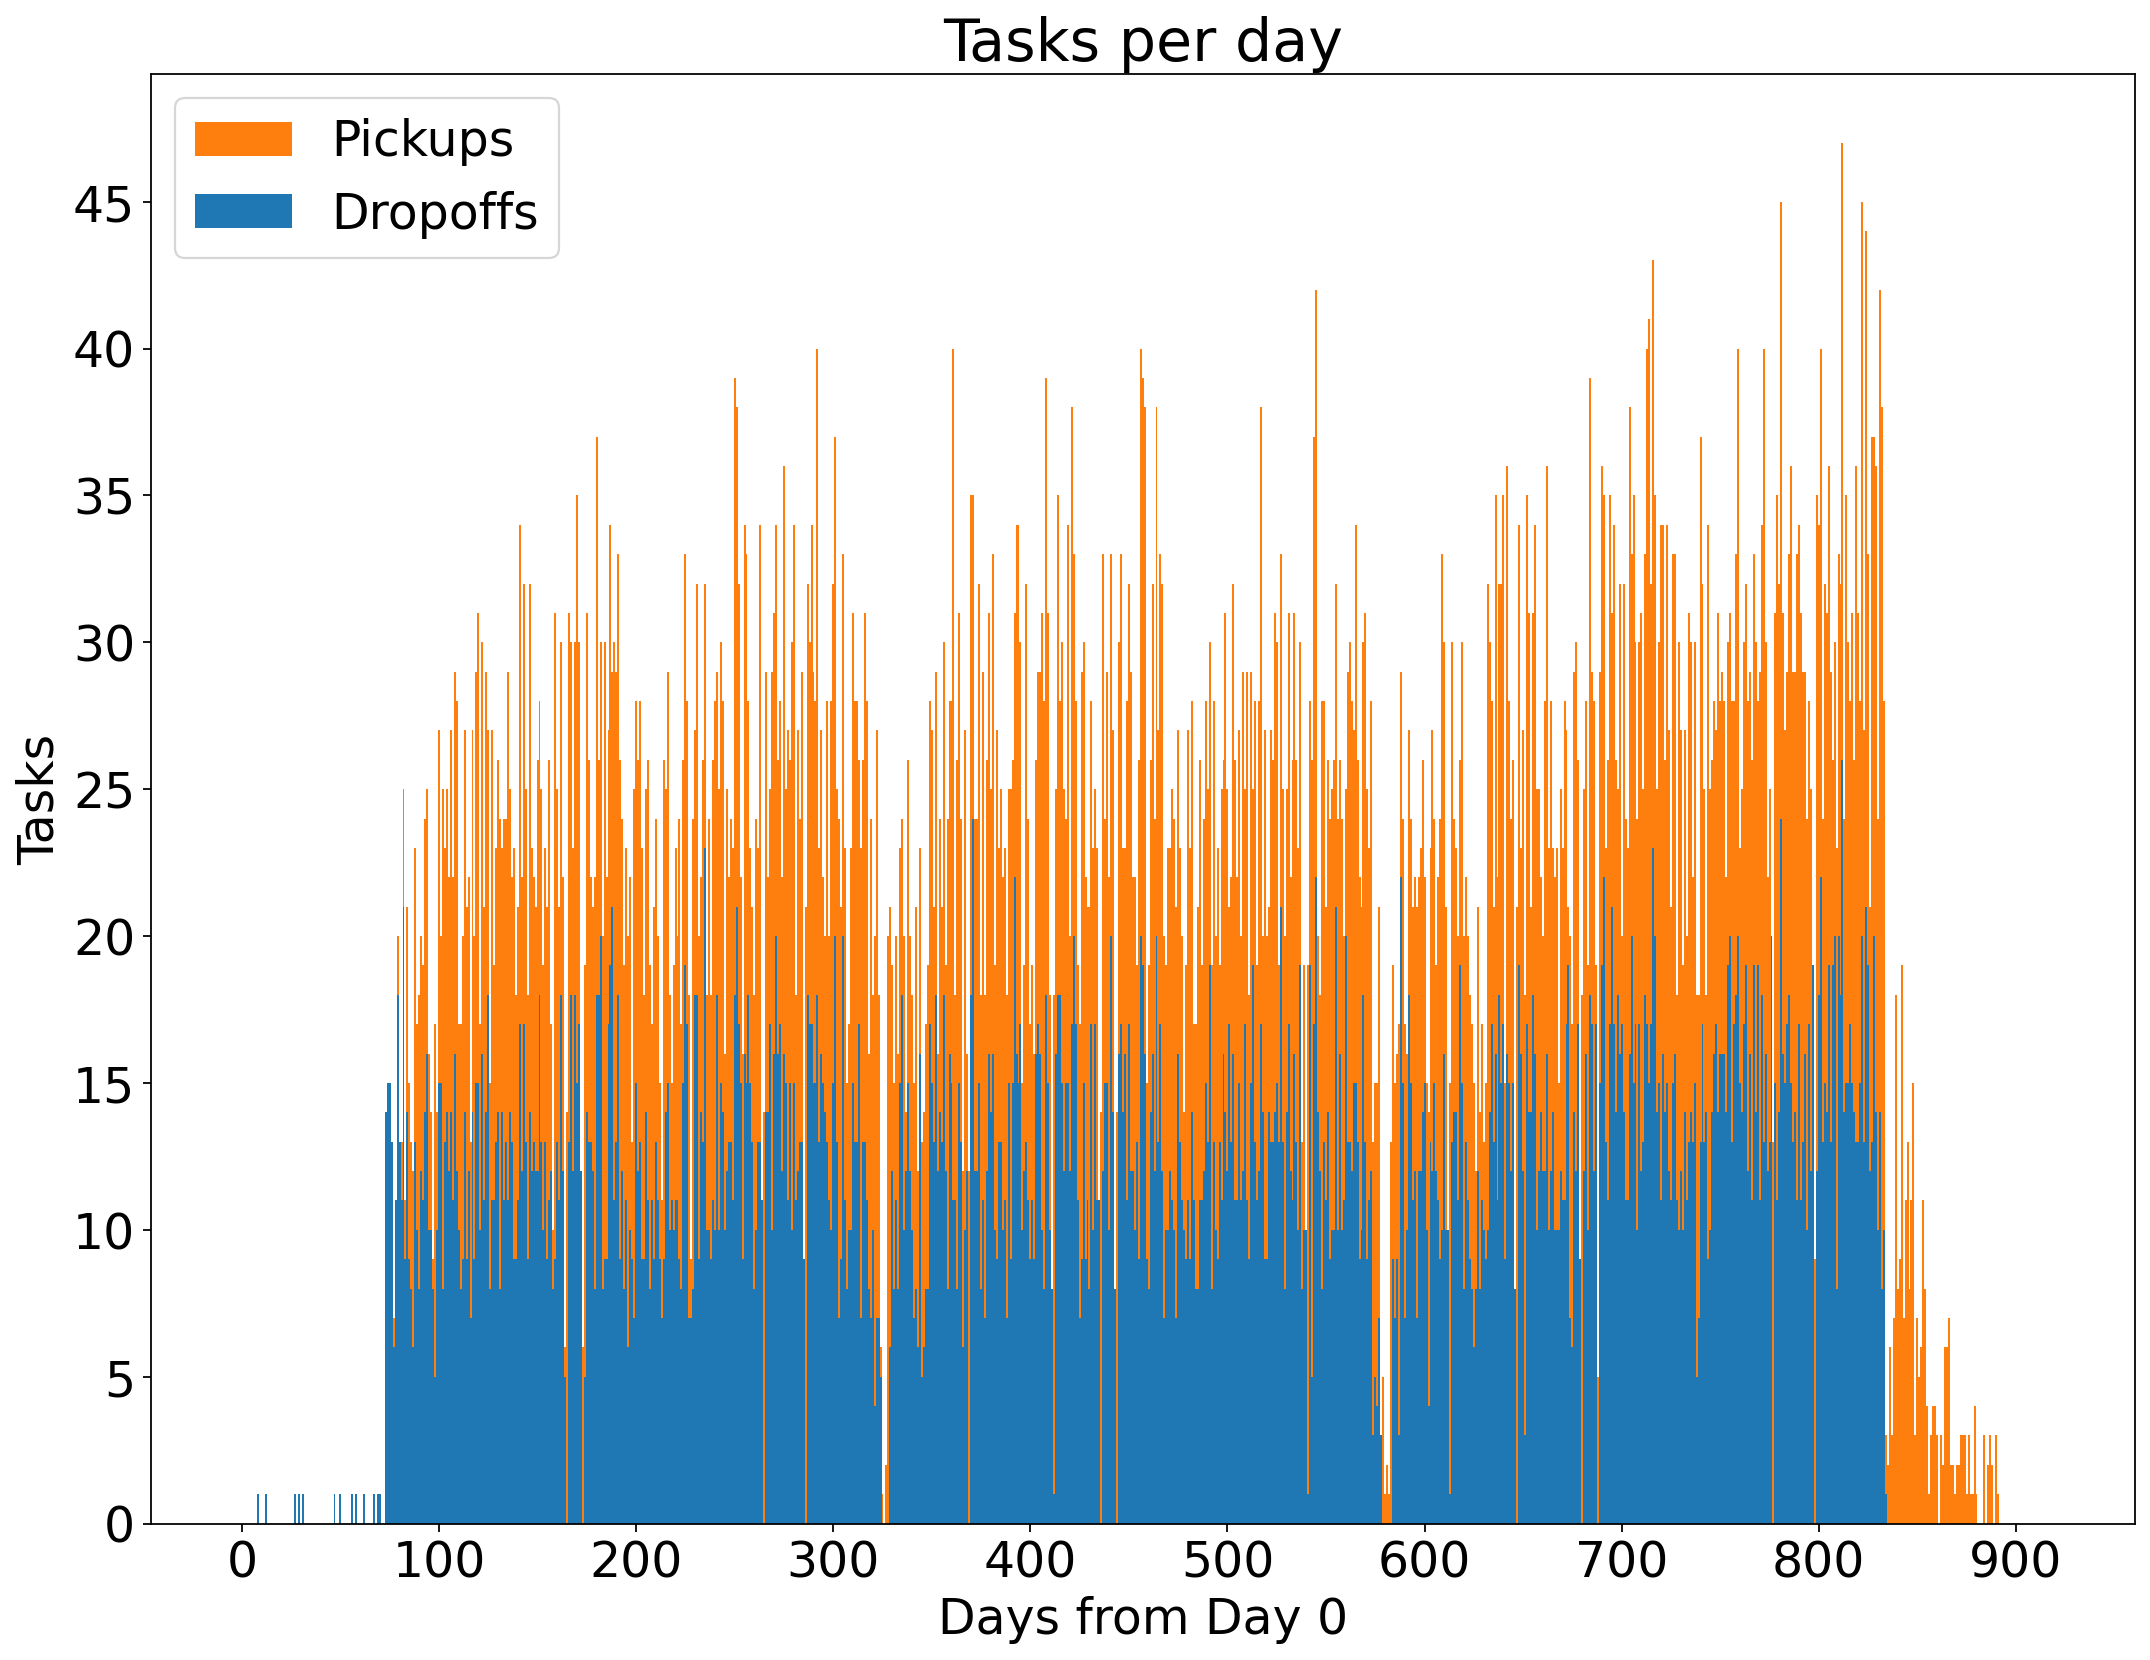

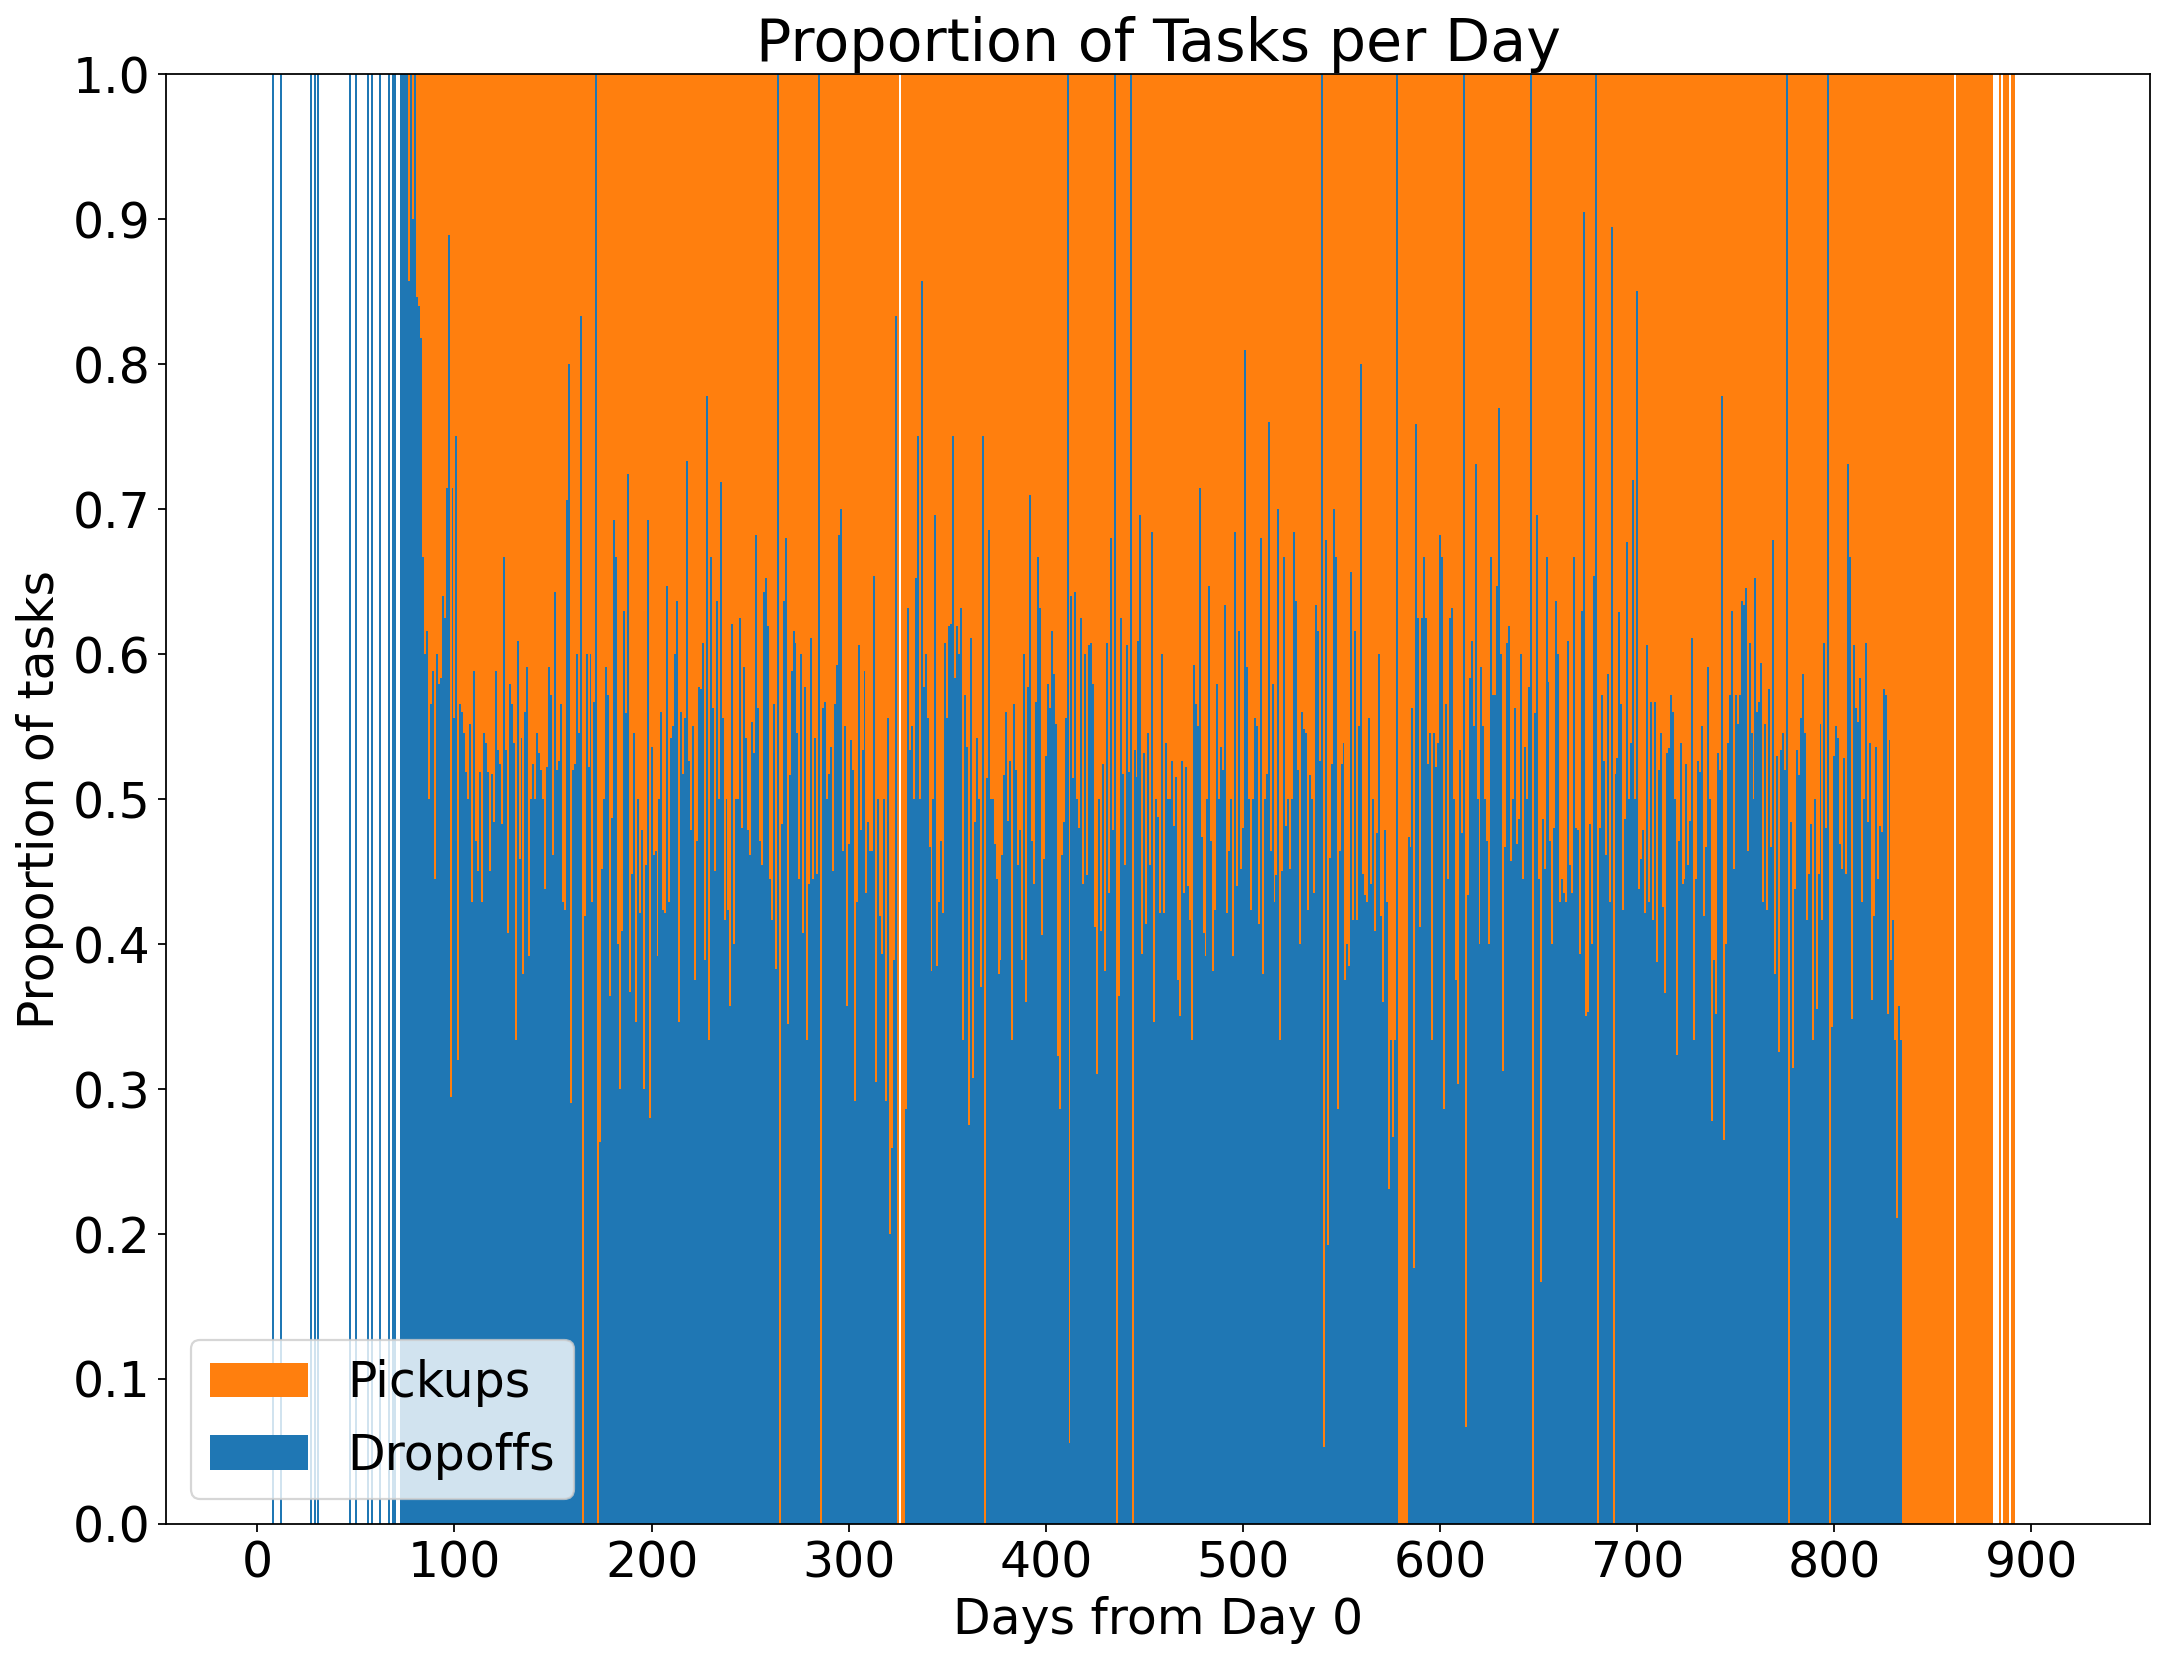

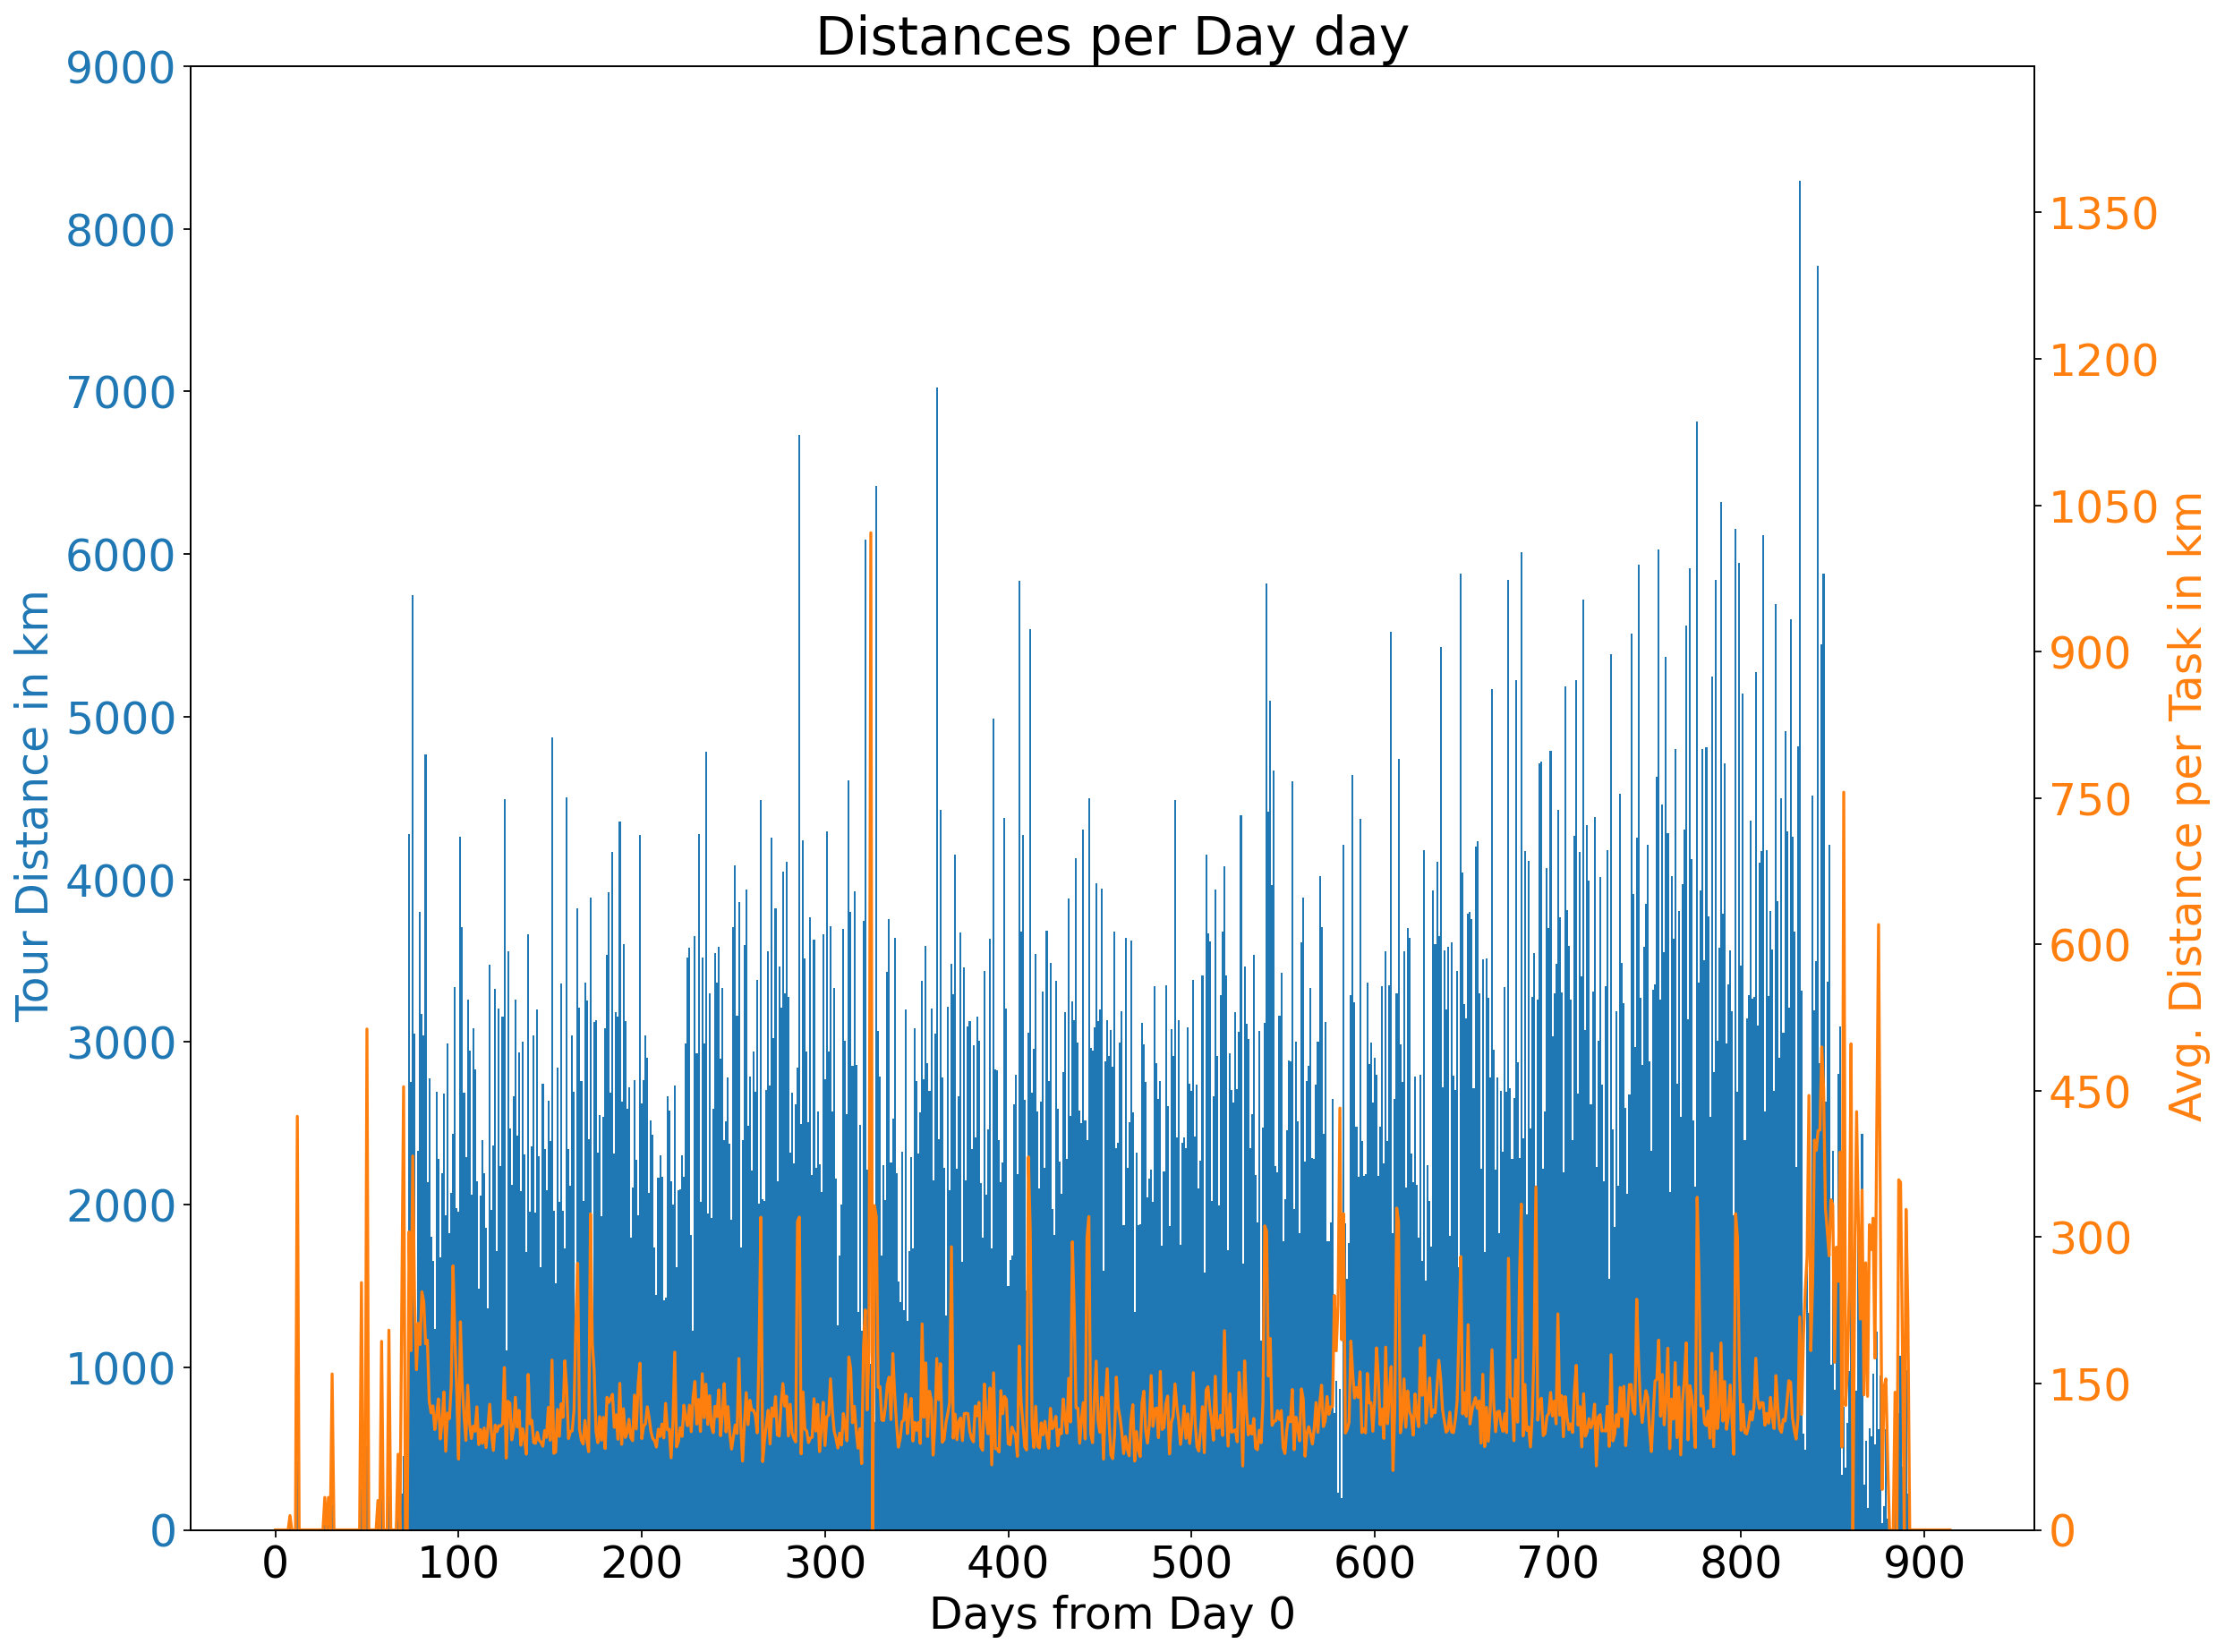

In [4]:
print("start here")
fc.print_log("Start Inital Solution Plot")

#only work with one depot
temp_depot = dict_depots['Neuss']
list_depots = [temp_depot]
dict_depots = {'Neuss': temp_depot}



solution_initial = cl.Solution(temp_depot,dict_tours,list_days)

solution_initial.plot_tasks(50,exp_prefix = img_exp_path + 'solution_inital_')
solution_initial.plot_task_proportion(exp_prefix = img_exp_path + 'solution_inital_')
solution_initial.plot_distances(10000,1500,exp_prefix = img_exp_path + 'solution_inital_')

fc.print_log("Done with  Inital Solution Plot")


After having a look at the inital solution, start optimizing

Stage 1: Try to level out the proportions between dropoff and pickup on eatch job

In [ ]:
fc.print_log("Start with Stage 1a")
#dict_tours_temp = copy.deepcopy(dict_tours)
dict_tours_temp = dict_tours
moves_possible = True
move_type = 'pickup'
move_count = 0
loop_count = 0
step_count = 0
step_count_curr = 0


#define temperature schedule
temperature = sa.Geometric_Schedule(1,0.95,200)
current_temp = temperature.temp_initial
#define acceptance function
acceptance = sa.ExponentialAcceptance(solution_initial.total_distance)
#define overall statistic
dict_statistic = {0: [solution_initial.total_distance, temperature.temp_initial, 0,0]}



fc.print_log("Start Random Moves with heuristics")
while loop_count < 10000:
    loop_count += 1
    move_made = False
    move_type = 'pickup'

    for depot in dict_depots:

        #find move
        tour_org, move_job, tour_new = sa.find_single_move_opposite(move_type, depot, dict_tours_temp,list_days)

        #evaluate move
        distance_delta = sa.evaluate_move(move_type,tour_org,tour_new,move_job)

        #check for acceptance - if accepted, reassign
        if acceptance.get_acc(current_temp,distance_delta):

            #perform move
            distance_delta = sa.reassign_job(move_type,tour_org,tour_new,move_job)

            #adjust move_bol, statistic and leave for loop
            move_made = True
            move_count +=1
            current_temp = temperature.get_temp(move_count)

            last_total_distance = dict_statistic[move_count-1][0]
            dict_statistic[move_count] = [last_total_distance + distance_delta,\
                                                               current_temp, move_count,loop_count]

        #switch move type so moves are performend in a switching order
        if move_type == 'pickup': move_type = 'dropoff'
        else: move_type = 'pickup'


    print("Current: Loop: {} - Moves: {}                                  ".format(loop_count,move_count),end='\r')
    #export statistics every n iterations
    for i in range(20):
        if loop_count == 500 * i + 1:
            fc.print_log("logging at %s" % loop_count)
            solution_stage_1atemp = cl.Solution(temp_depot,dict_tours_temp,list_days,dev_curr=dict_statistic)
            solution_stage_1atemp.plot_tasks(50, exp_prefix = img_exp_path + 'over_time/solution_stage1a_L{}_'.format(loop_count),plot=False)
            solution_stage_1atemp.plot_task_proportion(exp_prefix = img_exp_path + 'over_time/solution_stage1a_L{}_'.format(loop_count),plot=False)
            solution_stage_1atemp.plot_developement(exp_prefix = img_exp_path + 'over_time/solution_stage1a_L{}_'.format(loop_count),plot=False)

if loop_count > 9999:
    fc.print_log("Loopcount exit")

fc.print_log("Final: Loop: {} - Moves: {}".format(loop_count,move_count))

fc.print_log("Done with Moves")

solution_stage1a = cl.Solution(temp_depot,dict_tours_temp,list_days,dev_curr=dict_statistic)

solution_stage1a.plot_tasks(50,exp_prefix = img_exp_path + 'solution_stage1a')
solution_stage1a.plot_task_proportion(exp_prefix = img_exp_path + 'solution_stage1a')
solution_stage1a.plot_developement(exp_prefix = img_exp_path + 'solution_stage1a')
fc.dict_to_csv(dict_statistic,img_exp_path, 'sa_random_stage_1a')


fc.print_log("Done with Stage 1a")
steps_1a = step_count

#worst pair heuristic

Start with Stage 1a- t: 17:00:39
Start Random Moves with heuristics- t: 17:00:39
logging at 1- t: 17:00:41 1                                  
logging at 501- t: 17:13:40 501                                  
logging at 1001- t: 17:26:42 1001                                  
logging at 1501- t: 17:39:11 1501                                  


In [ ]:
print("old distance: %s" % solution_initial.total_distance)
print("new distance: %s" % solution_stage1a.total_distance)






In [ ]:
fc.save_object(solution_stage1a, img_exp_path + 'solution_stage1a.pkl')
